In [0]:
import torch
import random
import numpy as np
import os

import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
from google.colab import drive
drive.mount("/content/drive")

path = 'drive/My Drive/Projects/resnet_cifar10'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Download the data and look at it

In [0]:
from utils.load_data import load_data
from utils.train import train
from utils.train_optimized import train_optimized
from utils.draw_graphs import acc_loss_graph

In [4]:
X_train, y_train, X_test, y_test = load_data()

print(X_train.shape, y_train.shape)

Files already downloaded and verified
Files already downloaded and verified
CIFAR classes:
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([50000, 3, 32, 32]) torch.Size([50000])


    tensor(6)      tensor(9)      tensor(9)      tensor(4)      tensor(1)      tensor(1)      tensor(2)      tensor(7)      tensor(8)      tensor(3)      

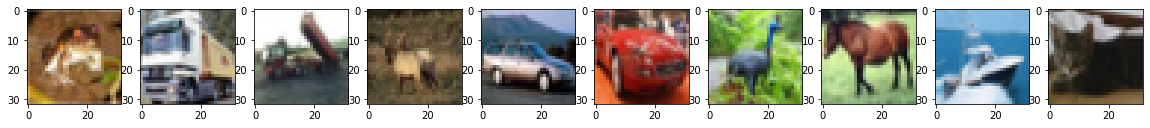

In [5]:
plt.figure(figsize=(20,2))
print('', end='    ')
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].permute(1, 2, 0))
    print(y_train[i], end='      ')

## 2. Train CIFARNet

In [0]:
from nnets.CIFARNet import CIFARNet

In [7]:
accuracies = {}
losses = {}

# Use train.py function to train CIFARNet
# CIFARNet - is the simple newral-net for cifar10 dataset

accuracies['cifar_net'], losses['cifar_net'] = \
    train(CIFARNet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:00:21 Accuracy: 0.701, GPU_Mem_alloc: 4.173 GB, GPU_Mem_cashed: 4.305 GB
Train Epoch: 20 Time: 00:00:42 Accuracy: 0.708, GPU_Mem_alloc: 4.173 GB, GPU_Mem_cashed: 4.305 GB
Train Epoch: 30 Time: 00:01:03 Accuracy: 0.7, GPU_Mem_alloc: 4.173 GB, GPU_Mem_cashed: 4.305 GB
Train Epoch: 40 Time: 00:01:23 Accuracy: 0.704, GPU_Mem_alloc: 4.173 GB, GPU_Mem_cashed: 4.305 GB
Train Epoch: 50 Time: 00:01:44 Accuracy: 0.702, GPU_Mem_alloc: 4.173 GB, GPU_Mem_cashed: 4.305 GB


In [14]:
# Clear the GPU-cache memory

torch.cuda.empty_cache()
round(torch.cuda.memory_allocated() / 1024**3, 3), round(torch.cuda.memory_cached() / 1024**3, 3)

(0.0, 0.0)

In [11]:
# Use train_optimized.py function to train CIFARNet

accuracies['cifar_net'], losses['cifar_net'] = \
    train_optimized(CIFARNet(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:00:21 Accuracy: 0.695, GPU_Mem_alloc: 0.133 GB, GPU_Mem_cashed: 1.604 GB
Train Epoch: 20 Time: 00:00:43 Accuracy: 0.693, GPU_Mem_alloc: 0.133 GB, GPU_Mem_cashed: 1.604 GB
Train Epoch: 30 Time: 00:01:04 Accuracy: 0.693, GPU_Mem_alloc: 0.133 GB, GPU_Mem_cashed: 1.604 GB
Train Epoch: 40 Time: 00:01:26 Accuracy: 0.701, GPU_Mem_alloc: 0.133 GB, GPU_Mem_cashed: 1.604 GB
Train Epoch: 50 Time: 00:01:47 Accuracy: 0.697, GPU_Mem_alloc: 0.133 GB, GPU_Mem_cashed: 1.604 GB


- We can see that using train_optimized allows us to spend much less GPU-memory, as this realization doesn't track computation history while evaluating validation loss

- Therefore, we will continue to use train_optimized farther


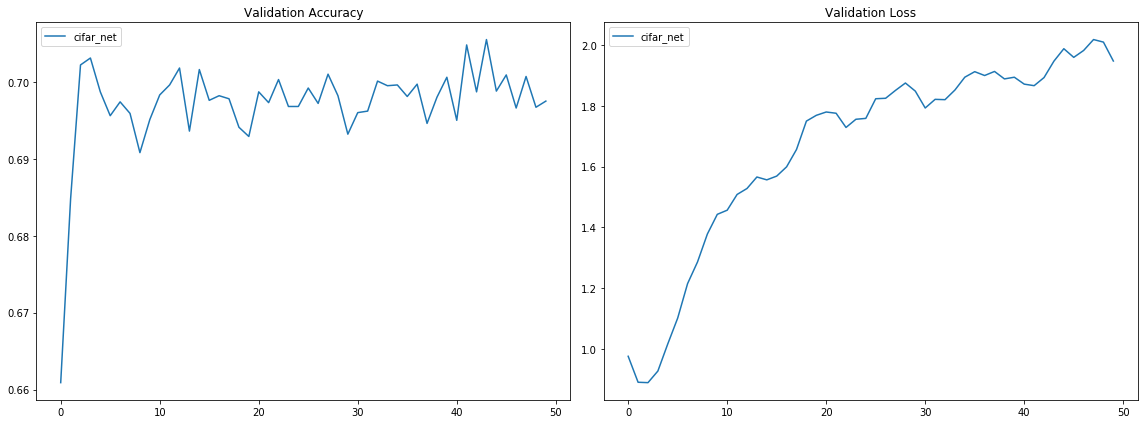

In [15]:
# Draw accuracy-loss graphs

acc_loss_graph(accuracies, losses)

## 3. Train resnet18

In [16]:
from torchvision.models import resnet18


accuracies['resnet18'], losses['resnet18'] = \
    train_optimized(resnet18(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:02:18 Accuracy: 0.667, GPU_Mem_alloc: 0.33 GB, GPU_Mem_cashed: 2.264 GB
Train Epoch: 20 Time: 00:04:37 Accuracy: 0.724, GPU_Mem_alloc: 0.33 GB, GPU_Mem_cashed: 2.264 GB
Train Epoch: 30 Time: 00:06:55 Accuracy: 0.742, GPU_Mem_alloc: 0.33 GB, GPU_Mem_cashed: 2.264 GB
Train Epoch: 40 Time: 00:09:13 Accuracy: 0.742, GPU_Mem_alloc: 0.33 GB, GPU_Mem_cashed: 2.264 GB
Train Epoch: 50 Time: 00:11:32 Accuracy: 0.715, GPU_Mem_alloc: 0.33 GB, GPU_Mem_cashed: 2.264 GB


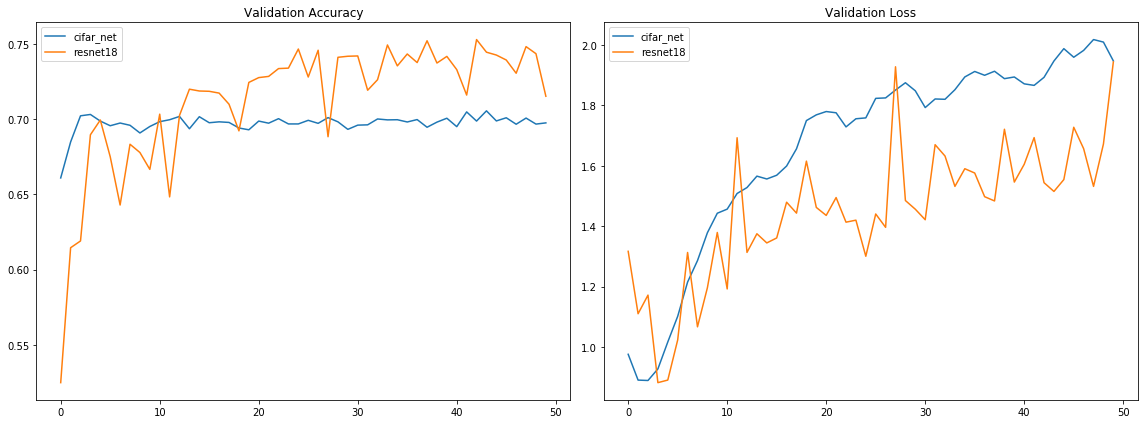

In [17]:
# Draw accuracy-loss graphs

acc_loss_graph(accuracies, losses)

- We got better quality than using CIFARNet
- However, resnet18 was designed for training on ImageNet dataset (shape: 224x224), instead of cifar10 dataset (shape: 32x32).

- Architectures of resnet for ImageNet dataset:

(Table 1 from: https://arxiv.org/pdf/1512.03385.pdf)

![alt text](https://miro.medium.com/max/1170/1*I2557MCaFdNUm4q9TfvOpw.png)

In [21]:
# Show number of parameters in resnet18

num_parameters = sum(p.numel() for p in resnet18().parameters())
print('Number of parameters = ', num_parameters)

Number of parameters =  11689512


## 4. Train resnet20

- For cifar10 dataset authors proposed the use of architectures: resnet20, resnet32, resnet44, resnet56 and so on
- There are totally 6n+2 stacked weighted
layers: for example, n=3 leads to 20 layers, and n=18 leads to 110 layers
- The following table summarizes the architectures: 


![alt text](https://miro.medium.com/max/530/1*tsMTDv-IBNlF_r4YkDBDvA.png)

- For example, architecture for resnet20 should be:

(Image is from: https://towardsdatascience.com/resnets-for-cifar-10-e63e900524e0)

![alt text](https://miro.medium.com/max/960/1*chbylvv0Lts1hKEuOJix6g.png)

In [23]:
# Clear the GPU-cache memory

torch.cuda.empty_cache()
round(torch.cuda.memory_allocated() / 1024**3, 3), round(torch.cuda.memory_cached() / 1024**3, 3)

(0.0, 0.0)

In [25]:
"""
My realisation of resnet20
"""
from nnets.resnet20_linear import resnet20_explicit

# Resnet20 with batchnorm, without dropout
accuracies['resnet20'], losses['resnet20'] = \
    train_optimized(resnet20_explicit(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:01:51 Accuracy: 0.784, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 2.434 GB
Train Epoch: 20 Time: 00:03:44 Accuracy: 0.78, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 2.434 GB
Train Epoch: 30 Time: 00:05:37 Accuracy: 0.783, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 2.434 GB
Train Epoch: 40 Time: 00:07:30 Accuracy: 0.78, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 2.434 GB
Train Epoch: 50 Time: 00:09:23 Accuracy: 0.784, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 2.434 GB


In [29]:
# Show number of parameters in linear resnet20

num_parameters = sum(p.numel() for p in resnet20_explicit().parameters())
print('Number of parameters = ', num_parameters)

Number of parameters =  269722


In [26]:
# Clear the GPU-cache memory

torch.cuda.empty_cache()
round(torch.cuda.memory_allocated() / 1024**3, 3), round(torch.cuda.memory_cached() / 1024**3, 3)

(0.0, 0.0)

In [28]:
"""
Realisation of resnet20 and resnet110 from:
https://github.com/akamaster/pytorch_resnet_cifar10
"""
from nnets.resnet_sequential import *

# Resnet20 with batchnorm, without dropout
accuracies['resnet20'], losses['resnet20'] = \
    train_optimized(resnet20(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:01:59 Accuracy: 0.717, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 3.135 GB
Train Epoch: 20 Time: 00:03:58 Accuracy: 0.758, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 3.135 GB
Train Epoch: 30 Time: 00:05:57 Accuracy: 0.79, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 3.135 GB
Train Epoch: 40 Time: 00:07:56 Accuracy: 0.795, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 3.135 GB
Train Epoch: 50 Time: 00:09:55 Accuracy: 0.8, GPU_Mem_alloc: 0.121 GB, GPU_Mem_cashed: 3.135 GB


In [30]:
# Show number of parameters in sequential resnet20

num_parameters = sum(p.numel() for p in resnet20().parameters())
print('Number of parameters = ', num_parameters)

Number of parameters =  269722


Three main points of comparison:
- The same architecture and same number of parameters
- Resnet20 linear implementation learns faster to maximum quality and doesn't go higher
- The sequential resnet20 implementation consumes slightly more GPU-cache memory

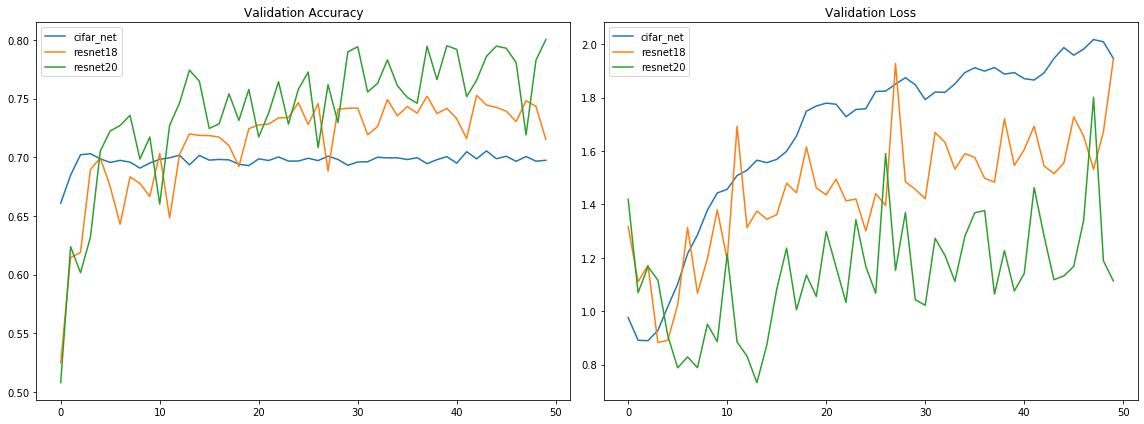

In [31]:
# Draw accuracy-loss graphs

acc_loss_graph(accuracies, losses)

## 4. Train resnet110

In [32]:
# Clear the GPU-cache memory

torch.cuda.empty_cache()
round(torch.cuda.memory_allocated() / 1024**3, 3), round(torch.cuda.memory_cached() / 1024**3, 3)

(0.0, 0.0)

In [33]:
# Resnet110 with batchnorm, without dropout
accuracies['resnet110'], losses['resnet110'] = \
    train_optimized(resnet110(), X_train, y_train, X_test, y_test)

Train Epoch: 10 Time: 00:11:51 Accuracy: 0.752, GPU_Mem_alloc: 0.143 GB, GPU_Mem_cashed: 5.617 GB
Train Epoch: 20 Time: 00:23:42 Accuracy: 0.789, GPU_Mem_alloc: 0.143 GB, GPU_Mem_cashed: 5.617 GB
Train Epoch: 30 Time: 00:35:33 Accuracy: 0.82, GPU_Mem_alloc: 0.143 GB, GPU_Mem_cashed: 5.617 GB
Train Epoch: 40 Time: 00:47:23 Accuracy: 0.825, GPU_Mem_alloc: 0.143 GB, GPU_Mem_cashed: 5.617 GB
Train Epoch: 50 Time: 00:59:11 Accuracy: 0.818, GPU_Mem_alloc: 0.143 GB, GPU_Mem_cashed: 5.617 GB


In [35]:
# Show number of parameters in sequential resnet110

num_parameters = sum(p.numel() for p in resnet110().parameters())
print('Number of parameters = ', num_parameters)

Number of parameters =  1727962


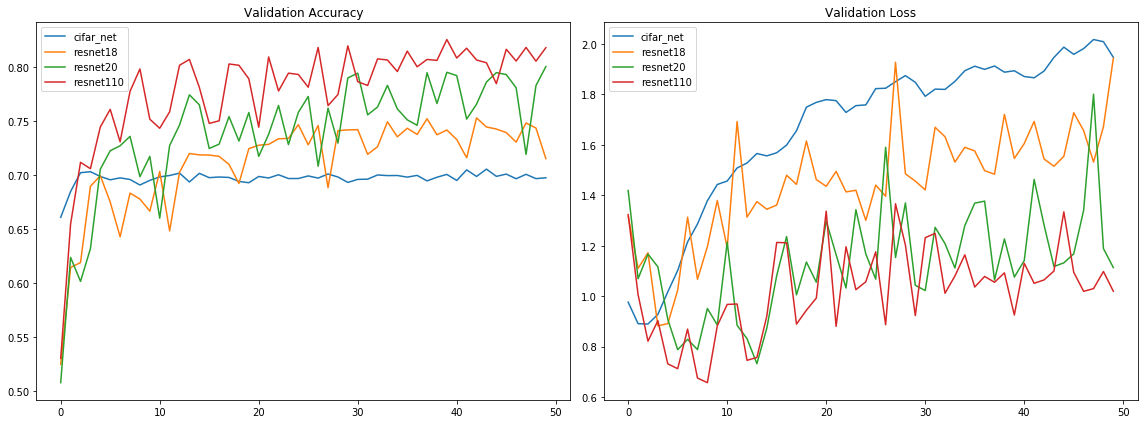

In [36]:
# Draw accuracy-loss graphs

acc_loss_graph(accuracies, losses)